# Sample Analytical Queries

In [15]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

config = ConfigParser()
config.read('./../dwh.cfg')

HOST = config.get('CLUSTER', 'HOST')
DB_NAME = config.get('CLUSTER', 'DB_NAME')
DB_USER = config.get('CLUSTER', 'DB_USER')
DB_PASSWORD = config.get('CLUSTER', 'DB_PASSWORD')
DB_PORT = config.get('CLUSTER', 'DB_PORT')

conn_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{HOST}:{DB_PORT}/{DB_NAME}"
conn = create_engine(conn_string, client_encoding="UTF-8")

## 1. Which songs are mostly listened by paid customers?

In [18]:
pd.read_sql(f"""
select s.title, ar.name, COUNT(*) as count from songplays sp
  left join songs s ON sp.song_id = s.song_id
  left join users u on sp.user_id = u.user_id
  left join artists ar on sp.artist_id = ar.artist_id
  where u.level = 'paid'
  group by s.title, ar.name
  order by count desc
  limit 20;
""", con = conn, index_col=['title', 'name', 'count'])

Empty DataFrame
Columns: []
Index: [(Nothin' On You [feat. Bruno Mars] (Album Version), B.o.B, 32), (You're The One, Dwight Yoakam, 30), (Revelry, Kings Of Leon, 25), (Somebody To Love, Justin Bieber / Usher, 22), (Somebody To Love, Justin Bieber, 22), (Somebody To Love, Justin Bieber / Jessica Jarrell, 22), (Yellow, Coldplay, 20), (Sehr kosmisch, Katy Perry, 17), (Sehr kosmisch, Harmonia, 17), (Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile), Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner, 17), (Stronger, Kanye West, 16), (Stronger, Kanye West / Consequence / Cam'Ron, 16), (Canada, Five Iron Frenzy, 16), (Stronger, Kanye West / GLC / Consequence, 16), (Stronger, Kanye West / Nas / Really Doe, 16), (Secrets, OneRepublic, 16), (Stronger, Kanye West / T-Pain, 16), (Bubble Toes, Jack Johnson, 14), (Bubble Toes, Jack Johnson / Paula Fuga, 14), (Dog Days Are Over (Radio Edit), Florence + The Machine, 13)]

## 2. How often do customers listen to music on days of the week?

In [19]:
pd.read_sql(f"""
select t.weekday, COUNT(*) as count from songplays sp
  left join "time" t on t.start_time = sp.start_time
  group by t.weekday
  order by t.weekday;
""", con = conn, index_col=['weekday', 'count'])

,
weekday,count
0,388
1,973
2,1036
3,1319
4,1020
5,1261
6,609


## 3. How Frequently Paid and Unpaid Users Use The App

In [27]:
df_song_play_daily_counts = pd.read_sql(f"""
select sp.level, t.year, t.month, t.day, COUNT(*) as count from songplays sp
  inner join time t on t.start_time = sp.start_time
  group by sp.level, t.year, t.month, t.day
  order by t.year, t.month, t.day;
""", con = conn)

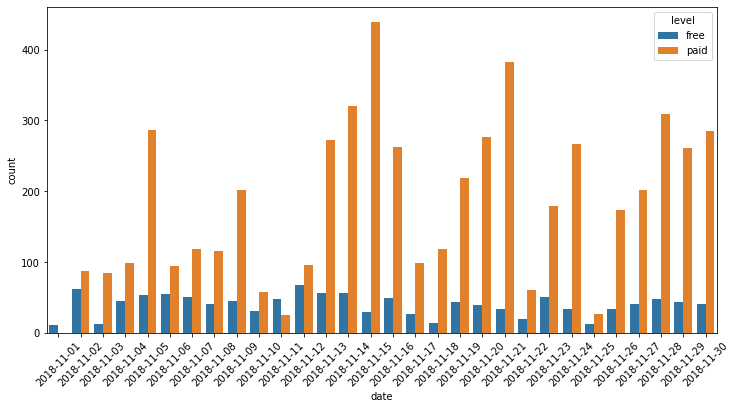

In [48]:
from datetime import date

df_song_play_daily_counts['date'] = df_song_play_daily_counts.apply(
    lambda row: date(row["year"], row["month"], row["day"]), axis=1);

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(data=df_song_play_daily_counts, x="date", y="count", hue="level", estimator=sum, ci=None, ax=ax);
plt.xticks(rotation = 45);